General & Temporial Analysis
===================

This is a series of notebooks used on my research of the literature review on the iterated prisoner's dilemma.

This section follows a circumstantial review of the prisoner's dilemma timeline
conducted by the authors. The section focuses on the analysis of the 
prisoner's dilemma timeline using a large dataset of prisoner's dilemma articles'
metadata.

Using various machine learning techniques the number and topics that have been
researched over the years within the field are discussed. Moreover, we 
explore the connections of the authors that have work on the game using
network theory.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_json('../data/pd_November_2018_clean.json')

**Total number of articles.**

In [3]:
total_articles = len(df['unique_key'].unique())
total_articles

3637

In [4]:
file = open("../../assets/total_articles.txt", 'w')
file.write('{}'.format(total_articles))
file.close()

In [5]:
df = df.replace('None', np.nan)

**Unique titles**

In [6]:
len(df['title'].unique()), len(df['unique_key'].unique())

(3637, 3637)

**Numbers of author and year range.**

In [7]:
number_of_authors = len(df['author'].unique())
number_of_authors

2668

In [8]:
file = open("../../assets/number_of_authors.txt", 'w')
file.write('{}'.format(number_of_authors))
file.close()

Provenance
----------

The total number of articles is given above. Here we can illustrate the provenance of these articles.
Thus we can see from which journal they have been collected and how many articles have been added by us. The table below shows the number of articles for each provenance.

In [9]:
provenance_size = df.groupby(['unique_key', 'provenance']).size().reset_index().groupby('provenance').size()

In [10]:
file = open("../../assets/prov_manual.txt", 'w')
file.write('{}'.format(provenance_size ['Manual']))
file.close()

In [11]:
provenance_size = provenance_size.apply(lambda x: round(x / total_articles * 100, 2))

In [12]:
provenance_table = pd.DataFrame(provenance_size, columns=['Percentage'])

In [13]:
provenance_table = provenance_table.sort_values(by='Percentage')

In [14]:
file = open("../../assets/provenance_table.tex", 'w')
file.write('{}'.format(provenance_table.to_latex()))
file.close()

Temporal Analysis
-----------------

In the general analysis section we looked at the number of articles collected from each journal and wheather they have been added manually.

In Figure Provenance the number of articles collected per year and per API are illustrated. Springer seems to have a continuous contribution on the data set from 1996 up to 2016. The total number of articles collected from Springer per year do not exceed 30. On the other hand, IEEE and arXiv, where both have a significant contribution to the data set, seem to have articles on the IPD only after the 2000s. Finally, both Nature and PLOS with a small significant contribution appear after the 2010s.

In [15]:
#df = pd.read_json('../data/data_dec_2017_clean.json')

In [16]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [17]:
font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [18]:
yearly_provenance = df.groupby(['unique_key','provenance', 'date']).size().reset_index().groupby(['provenance', 'date']).size()

In [19]:
yearly_df = df.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()

In [20]:
colors = list(matplotlib.cm.plasma(np.linspace(0, 1, 6)))
linestyles = [':', '--', '-', '--', '-', '--']

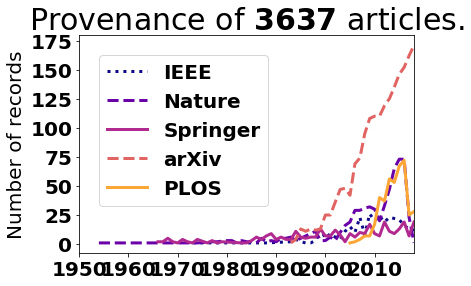

In [21]:
fig = plt.figure()

plt.title('Provenance of ${}$ articles.'.format(total_articles), fontsize=30)
plt.ylabel('Number of records', fontsize=20); plt.yticks(fontsize=20)
plt.xticks(fontsize=20); plt.xlim(1950, 2018)
    
for i, api in enumerate(['IEEE', 'Nature', 'Springer', 'arXiv', 'PLOS']):
    plt.plot(yearly_provenance[api], linestyle=linestyles[i], 
             label=api, linewidth=3, c=colors[i])

plt.legend(loc=2, borderaxespad=1, fontsize=20);
# plt.savefig("/home/nightwing/rsc/Literature-Article/assets/images/provenance.pdf", bbox_inches='tight')

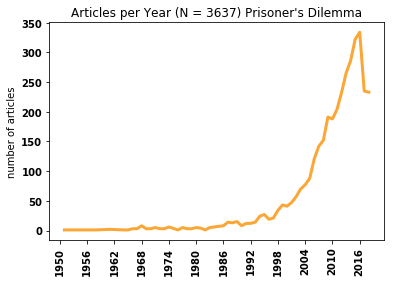

In [50]:
fig = plt.figure()

plt.plot(yearly_df, color=colors[4], zorder=1, linewidth=3);
plt.xticks(np.arange(1950, 2018, step=6), rotation=90);

plt.ylabel('number of articles');
plt.savefig("../../assets/images/timeline.pdf", bbox_inches='tight')
plt.title("Articles per Year (N = {}) Prisoner's Dilemma".format(total_articles));

In [23]:
x = range(37)
y = yearly_df[1980:2016].values

In [24]:
from scipy import optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

params, params_covariance = optimize.curve_fit(func, x, y, p0=[0, 0, 0])

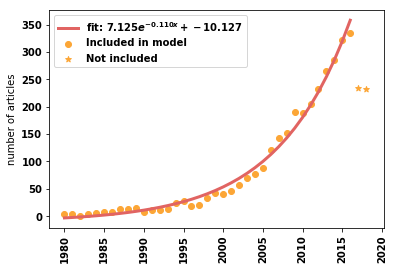

In [25]:
plt.figure(figsize=(6, 4))
plt.scatter(yearly_df[1980:2016].index, y, color=colors[4], zorder=1, linewidth=1, label='Included in model')
plt.plot(yearly_df[1980:2016].index, func(x, params[0], params[1], params[2]),
         label=r'fit: $ %5.3f e^{%5.3f x} +%5.3f$' % tuple(params), color=colors[3], zorder=2, linewidth=3)
plt.scatter(yearly_df[2017:2018].index, yearly_df[2017:2018].values, color=colors[4], zorder=1,
            linewidth=1, marker='*', label='Not included')
plt.xticks(rotation=90);
plt.legend(loc='best')

plt.ylabel('number of articles');
plt.savefig("../../assets/images/fitting.pdf", bbox_inches='tight')

In [26]:
xn = range(37, 42)

In [27]:
forecasting = [round(func(x_v, *params)) for x_v in xn]

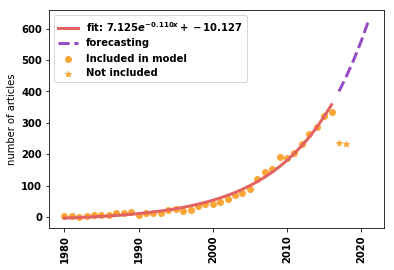

In [28]:
plt.figure(figsize=(6, 4))
plt.scatter(yearly_df[1980:2016].index, y, color=colors[4], zorder=1, linewidth=1, label='Included in model')
plt.plot(yearly_df[1980:2016].index, func(x, params[0], params[1], params[2]),
         label=r'fit: $ %5.3f e^{%5.3f x} +%5.3f$' % tuple(params), color=colors[3], zorder=2, linewidth=3)
plt.plot(range(2017, 2022), forecasting, label= 'forecasting', color=colors[1], zorder=2,
         linewidth=3, alpha=0.7, linestyle='--')
plt.scatter(yearly_df[2017:2018].index, yearly_df[2017:2018].values, color=colors[4], zorder=1,
            linewidth=1, marker='*', label='Not included')

plt.xticks(rotation=90);

plt.legend(loc='best')

plt.ylabel('number of articles');
plt.savefig("../../assets/images/forecasting.pdf", bbox_inches='tight')

In [29]:
index = range(2017, 2022)
forecasting_table = pd.DataFrame(forecasting, columns=['Forecast'], index=index)

In [30]:
file = open("../../assets/predictions.tex", 'w')
file.write('{}'.format(forecasting_table.to_latex()))
file.close()

Av. publication
------

The rate is calculated as the ratio of number of total articles and the number of years of publication.
Thus:
    $$ \text{rate}= \frac{\text{number of articles}}{\text{years of publication}}$$

In [31]:
(yearly_df.values.sum() / yearly_df.count())

61.59322033898305

In [32]:
rates = [np.round(yearly_df.values.sum() / yearly_df.count())]
for api in ['IEEE', 'Nature', 'PLOS', 'Springer', 'arXiv']:
    rates.append(np.round(yearly_provenance[api].values.sum() / yearly_df.count()))

In [33]:
rates_table = pd.DataFrame(rates, ['Overall', 'IEEE', 'Nature', 'PLOS', 'Springer', 'arXiv'], 
                           columns={'Av. publication'})

In [34]:
rates_table = rates_table.sort_values(by='Av. publication')

In [35]:
file = open("../../assets/rates_table.tex", 'w')
file.write('{}'.format(rates_table.to_latex()))
file.close()

Comparison Table
----------------

In [36]:
anarchy_df = pd.read_json('../data/anarchy_November_2018_clean.json')

In [37]:
auction_df = pd.read_json('../data/auction_November_2018_clean.json')

In [45]:
general_data = []
for data in [anarchy_df, auction_df]:
    total_size = len(data['title'].unique())
    authors = len(data['author'].unique())
    provenance = data.groupby(['unique_key', 'provenance']).size().reset_index().groupby('provenance').size()
    provenance = provenance.apply(lambda x: round(x / total_size * 100, 2))
    
    yearly = data.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()
    rate = np.round(yearly.values.sum() / yearly.count())
    
    general_data.append((total_size, authors, provenance.index, provenance.values, rate))

In [46]:
general_data[0]

(432,
 367,
 Index(['Nature', 'Springer', 'arXiv'], dtype='object', name='provenance'),
 array([48.38, 32.18, 19.44]),
 9.0)

In [48]:
general_data[1]

(1386,
 1041,
 Index(['IEEE', 'Nature', 'Springer', 'arXiv'], dtype='object', name='provenance'),
 array([ 0.72, 13.92, 65.51, 19.84]),
 29.0)

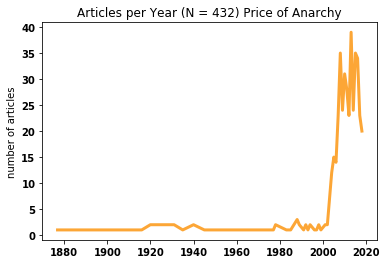

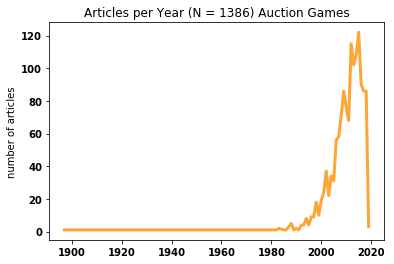

In [53]:
for data, label in zip([anarchy_df, auction_df], ['Price of Anarchy', 'Auction Games']):
    total = len(data['unique_key'].unique())
    
    yearly = data.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()

    fig = plt.figure()

    plt.plot(yearly.index, yearly.values, color=colors[4], zorder=1, linewidth=3);
    # plt.xticks(np.arange(1950, 2018, step=6), rotation=90);

    plt.ylabel('number of articles')
    plt.title("Articles per Year (N = {}) {}".format(total, label))
    plt.savefig("../../assets/images/{}.pdf".format(label), bbox_inches='tight')
    

In [60]:
min(anarchy_df.date.unique()), min(auction_df.date.unique())

(1877, 1897)

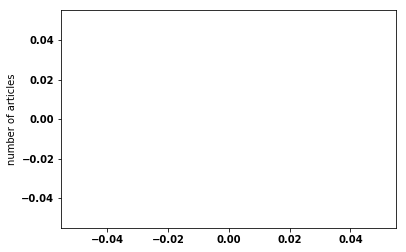

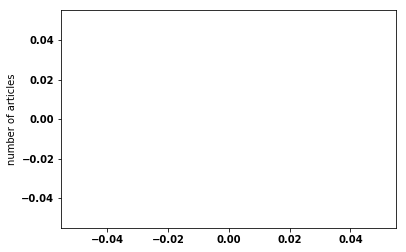

In [42]:
for data in [anarchy_df, auction_df]:
    yearly = data.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()

    fig = plt.figure()

    plt.scatter(yearly[1980:].index, yearly[1980:].values, color=colors[4], zorder=1, linewidth=3);
    # plt.xticks(np.arange(1950, 2018, step=6), rotation=90);

    plt.ylabel('number of articles');

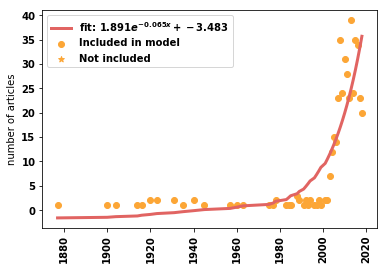

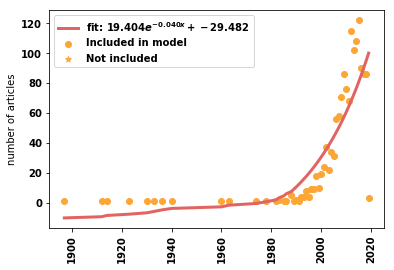

In [43]:
for data in [anarchy_df, auction_df]:
    yearly = data.groupby(['unique_key', 'date']).size().reset_index().groupby('date').size()
    
    y = yearly.values[:2016]
    x = range(len(yearly[:2016].index))
    
    params, params_covariance = optimize.curve_fit(func, x, y, p0=[0, 0, 0.1])
    
    plt.figure(figsize=(6, 4))
    
    plt.scatter(yearly[:2016].index, y, color=colors[4], zorder=1, linewidth=1, label='Included in model')
    plt.plot(yearly[:2016].index, func(x, params[0], params[1], params[2]),
             label=r'fit: $ %5.3f e^{%5.3f x} +%5.3f$' % tuple(params), color=colors[3], zorder=2, linewidth=3)
    plt.scatter(yearly[2017:2018].index, yearly[2017:2018].values, color=colors[4], zorder=1,
                linewidth=1, marker='*', label='Not included')
    plt.xticks(rotation=90);
    plt.legend(loc='best')

    plt.ylabel('number of articles');